In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
df = pd.read_csv('/content/airbnb_data.csv').drop(['id'],axis=1)
df.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [ ]:
df.columns

Index(['log_price', 'property_type', 'room_type', 'amenities', 'accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'description', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'latitude', 'longitude', 'name',
       'neighbourhood', 'number_of_reviews', 'review_scores_rating',
       'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

## Visualization :

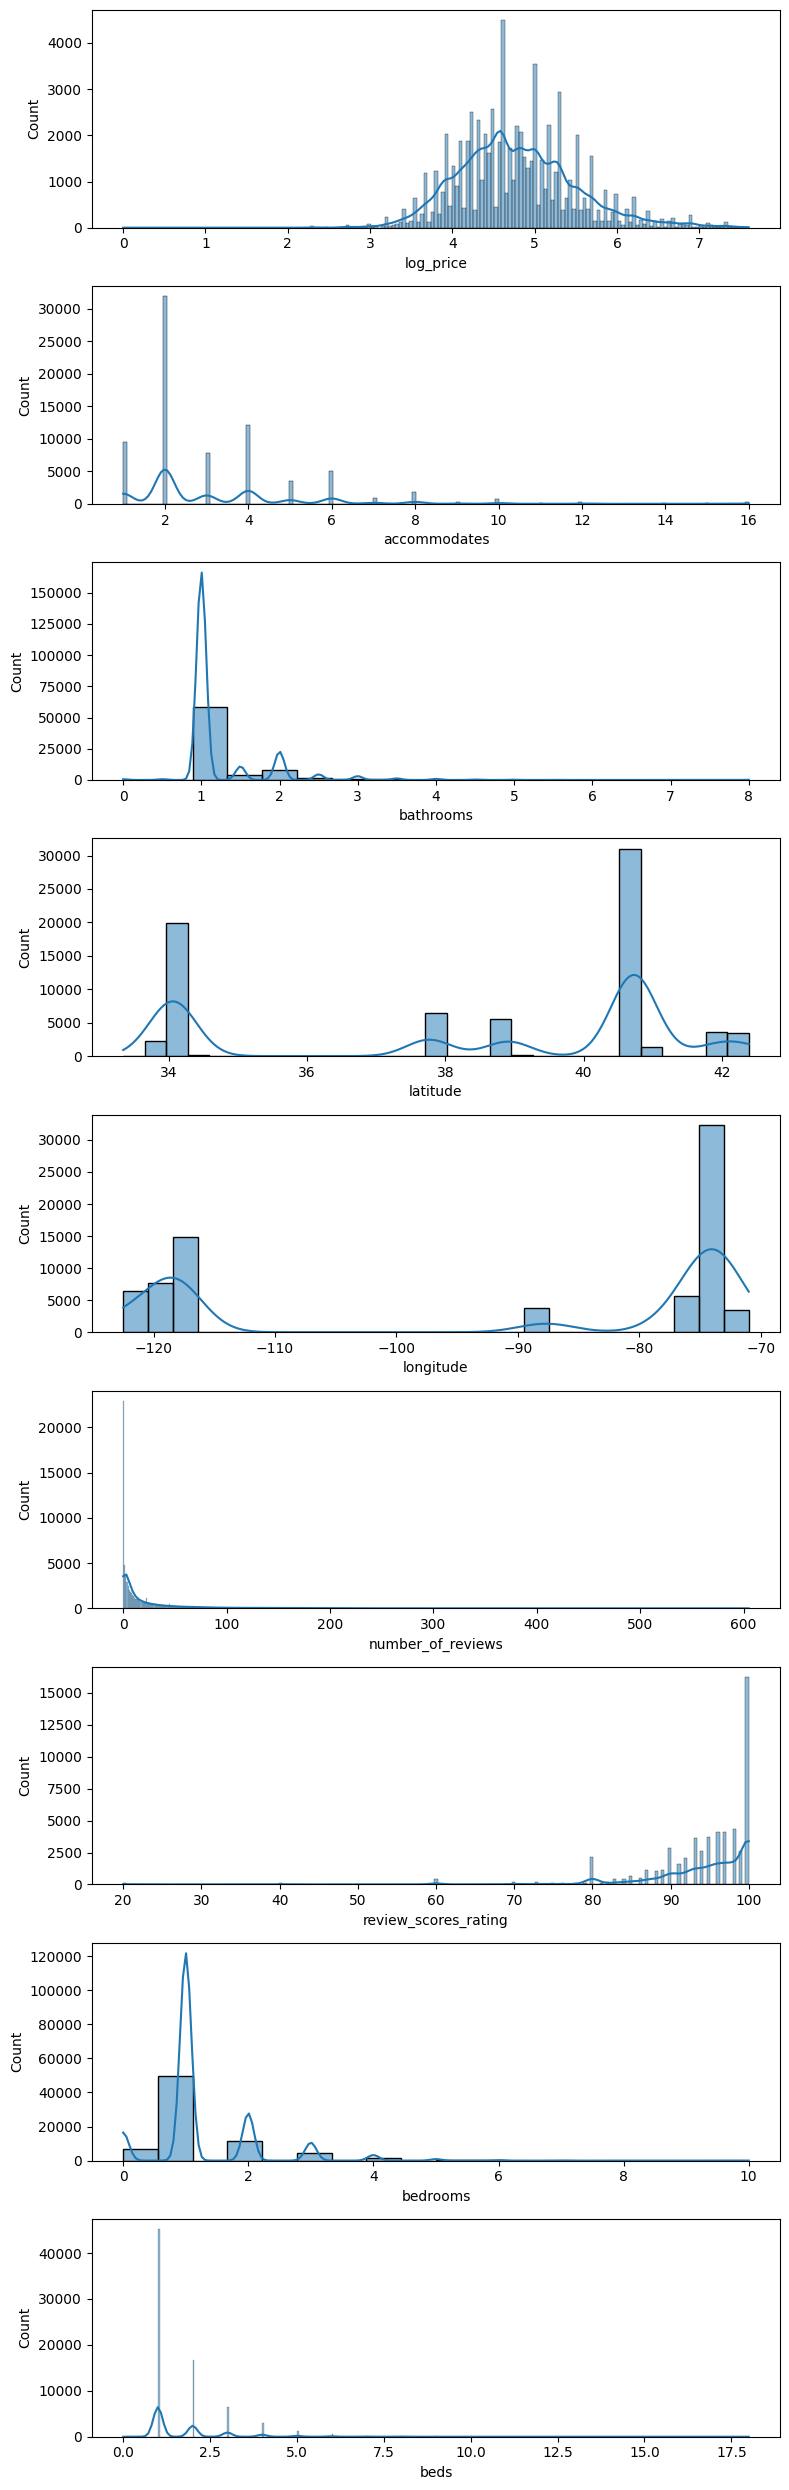

In [ ]:
# check the distributions (numerical)
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8,25))

numerical_columns = df.select_dtypes(include=['number']).columns.to_list()

for i,column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns),1,i+1)
    sns.histplot(x=df[column],kde=True)
    plt.tight_layout()

In [ ]:
# column summary function
def column_summary(df):

    summary_df = pd.DataFrame({
        'col_dtype' : df.dtypes.values,
        'num_of_nulls' : df.isnull().sum().values,
        'null%' : round((df.isnull().sum()/df.shape[0])*100, 2).values,
        'num_of_non_nulls' : df.count().values,
        'num_of_distinct_values' : df.nunique().values
    }, index=df.columns)

    ## extracting distinct_values_counts for summary_df
    distinct_values_counts = []
    for i in range(df.shape[1]):
        if summary_df['num_of_distinct_values'][i]<=10:
            distinct_values_counts.append(dict(zip(df[df.columns[i]].value_counts().index.to_list(),df[df.columns[i]].value_counts().values)))
        else:
            distinct_values_counts.append(dict(zip(df[df.columns[i]].value_counts().index.to_list()[:10],df[df.columns[i]].value_counts().values[:10])))

    summary_df['distinct_values_counts'] = distinct_values_counts

    return summary_df

summary = column_summary(df)
summary

,col_dtype,num_of_nulls,null%,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
log_price,float64,0,0.00,74111,767,"{5.010635294: 2729, 4.605170186: 2707, 4.31748..."
property_type,object,0,0.00,74111,35,"{'Apartment': 49003, 'House': 16511, 'Condomin..."
room_type,object,0,0.00,74111,3,"{'Entire home/apt': 41310, 'Private room': 306..."
amenities,object,0,0.00,74111,67122,"{'{}': 586, '{""translation missing: en.hosting..."
accommodates,int64,0,0.00,74111,16,"{2: 31854, 4: 12066, 1: 9434, 3: 7794, 6: 4969..."
bathrooms,float64,200,0.27,73911,17,"{1.0: 58099, 2.0: 7936, 1.5: 3801, 2.5: 1567, ..."
bed_type,object,0,0.00,74111,5,"{'Real Bed': 72028, 'Futon': 753, 'Pull-out So..."
cancellation_policy,object,0,0.00,74111,5,"{'strict': 32374, 'flexible': 22545, 'moderate..."
cleaning_fee,bool,0,0.00,74111,2,"{True: 54403, False: 19708}"
city,object,0,0.00,74111,6,"{'NYC': 32349, 'LA': 22453, 'SF': 6434, 'DC': ..."


## Handle Missing Values :

In [ ]:
# removing columns having more than 5% null values
summary = summary[summary['null%']<=5]

# removing unneccessary columns
features = summary.drop(['amenities', 'description', 'host_since', 'name', 'zipcode'], axis=0).index.values
df = df[features]    # --> new dataframe

# column summary of new df
summary = column_summary(df)
summary

,col_dtype,num_of_nulls,null%,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
log_price,float64,0,0.00,74111,767,"{5.010635294: 2729, 4.605170186: 2707, 4.31748..."
property_type,object,0,0.00,74111,35,"{'Apartment': 49003, 'House': 16511, 'Condomin..."
room_type,object,0,0.00,74111,3,"{'Entire home/apt': 41310, 'Private room': 306..."
accommodates,int64,0,0.00,74111,16,"{2: 31854, 4: 12066, 1: 9434, 3: 7794, 6: 4969..."
bathrooms,float64,200,0.27,73911,17,"{1.0: 58099, 2.0: 7936, 1.5: 3801, 2.5: 1567, ..."
bed_type,object,0,0.00,74111,5,"{'Real Bed': 72028, 'Futon': 753, 'Pull-out So..."
cancellation_policy,object,0,0.00,74111,5,"{'strict': 32374, 'flexible': 22545, 'moderate..."
cleaning_fee,bool,0,0.00,74111,2,"{True: 54403, False: 19708}"
city,object,0,0.00,74111,6,"{'NYC': 32349, 'LA': 22453, 'SF': 6434, 'DC': ..."
host_has_profile_pic,object,188,0.25,73923,2,"{'t': 73697, 'f': 226}"


In [ ]:
# filling null values
null_col = summary[summary['null%']>0].index.values
fill_values = [1.0,'t','t',1.0,1.0]

for i in range(len(null_col)):
    df[null_col[i]] = df[null_col[i]].fillna(fill_values[i])

In [ ]:
df.isnull().sum()

,0
log_price,0
property_type,0
room_type,0
accommodates,0
bathrooms,0
bed_type,0
cancellation_policy,0
cleaning_fee,0
city,0
host_has_profile_pic,0


## Handle Categorical Columns :

In [ ]:
df['cleaning_fee'] = df['cleaning_fee'].astype(str)
summary = column_summary(df)

In [ ]:
categorical_columns = summary[summary['col_dtype'] == 'object'].index
df = pd.get_dummies(df, columns=categorical_columns, dtype=np.int64, drop_first=True)

## Train Test Split :

In [ ]:
X = df.drop(['log_price'], axis=1)
y = df['log_price']

# split with 20% test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Model Training :

#### 1. Linear Regression --

In [ ]:
reg = LinearRegression()

reg.fit(X_train, y_train)

# evaluation
y_pred = reg.predict(X_test)

print(f'R2 : {r2_score(y_test, y_pred)}')
print(f'MAE : {mean_absolute_error(y_test, y_pred)}')
print(f'MSE : {mean_squared_error(y_test, y_pred)}')

R2 : 0.5768452206994458
MAE : 0.35149694172706347
MSE : 0.21738556922999644


#### 2. Random Forest Regressor --

In [ ]:
reg = RandomForestRegressor()

reg.fit(X_train, y_train)

# evaluation
y_pred = reg.predict(X_test)

print(f'R2 : {r2_score(y_test, y_pred)}')
print(f'MAE : {mean_absolute_error(y_test, y_pred)}')
print(f'MSE : {mean_squared_error(y_test, y_pred)}')

R2 : 0.690213466410764
MAE : 0.287527034201555
MSE : 0.1591453653327443


#### 3. XGBoost --

In [ ]:
reg = xgb.XGBRegressor(n_estimators=300)

reg.fit(X_train, y_train)

# evaluation
y_pred = reg.predict(X_test)

print(f'R2 : {r2_score(y_test, y_pred)}')
print(f'MAE : {mean_absolute_error(y_test, y_pred)}')
print(f'MSE : {mean_squared_error(y_test, y_pred)}')

R2 : 0.7006877752602125
MAE : 0.284895639821746
MSE : 0.15376444160717084


## Model Evaluation

In [ ]:
# final model as XGBoost

print(f'R2 : {r2_score(y_test, y_pred)}')
print(f'MAE : {mean_absolute_error(y_test, y_pred)}')
print(f'MSE : {mean_squared_error(y_test, y_pred)}')

R2 : 0.7006877752602125
MAE : 0.284895639821746
MSE : 0.15376444160717084
